Data successfully loaded into SQLite database!


C:\Users\kikas\AppData\Local\Temp\ipykernel_29808\2661472761.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inpatient_df.fillna("Unknown", inplace=True)
C:\Users\kikas\AppData\Local\Temp\ipykernel_29808\2661472761.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  outpatient_df.fillna("Unknown", inplace=True)


Data cleaning completed!
High-Risk Claims:
        BeneID   ClaimID ClaimStartDt  ClaimEndDt  Provider  \
9    BENE11034  CLM31519   2008-12-29  2009-01-05  PRV55215   
11   BENE11036  CLM70083   2009-09-30  2009-10-07  PRV51145   
51   BENE11174  CLM36482   2009-02-01  2009-02-15  PRV57191   
94   BENE11324  CLM79476   2009-12-13  2009-12-26  PRV54894   
156  BENE11589  CLM60798   2009-07-23  2009-07-30  PRV51948   

     InscClaimAmtReimbursed AttendingPhysician OperatingPhysician  \
9                     29000          PHY355604          PHY415867   
11                    30000          PHY329774            Unknown   
51                    31000          PHY398500          PHY346614   
94                    33000          PHY424317          PHY424317   
156                   30000          PHY361948          PHY361948   

    OtherPhysician AdmissionDt  ... ClmDiagnosisCode_8 ClmDiagnosisCode_9  \
9          Unknown  2008-12-29  ...               4111               4589   
11       

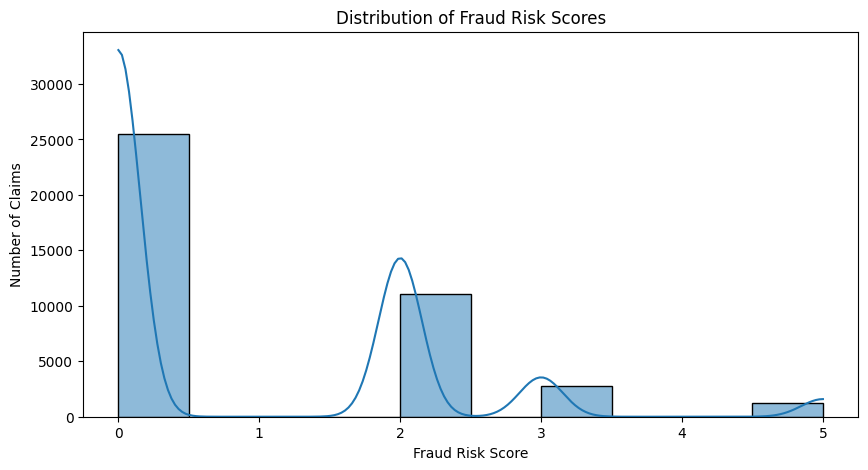

2025-02-25 19:13:13.131 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.797 
  command:

    streamlit run C:\Users\kikas\AppData\Roaming\Python\Python313\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-02-25 19:13:13.797 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.799 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-25 19:13:13.801 Thre

Data Dictionary Created!


In [7]:
# Import necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import unittest

# -------------------------
# SECTION 1: DATA INGESTION
# -------------------------

# Connect to SQLite database
conn = sqlite3.connect("insurance_fraud.db")

# Define dataset file paths
file_paths = {
"beneficiaries":r"C:\Users\kikas\Desktop\Python\Capstone project\Code\Data\Train_Beneficiarydata-1542865627584.csv",
"inpatient":r"C:\Users\kikas\Desktop\Python\Capstone project\Code\Data\Train_Inpatientdata-1542865627584.csv",
"outpatient":r"C:\Users\kikas\Desktop\Python\Capstone project\Code\Data\Train_Outpatientdata-1542865627584.csv",
"providers":r"C:\Users\kikas\Desktop\Python\Capstone project\Code\Data\Train-1542865627584.csv"
}

# Load datasets into Pandas DataFrames
beneficiaries_df = pd.read_csv(file_paths["beneficiaries"])
inpatient_df = pd.read_csv(file_paths["inpatient"])
outpatient_df = pd.read_csv(file_paths["outpatient"])
providers_df = pd.read_csv(file_paths["providers"])

# Insert data into SQL tables
beneficiaries_df.to_sql("beneficiaries", conn, if_exists="replace", index=False)
inpatient_df.to_sql("inpatient_claims", conn, if_exists="replace", index=False)
outpatient_df.to_sql("outpatient_claims", conn, if_exists="replace", index=False)
providers_df.to_sql("providers", conn, if_exists="replace", index=False)

print("Data successfully loaded into SQLite database!")

# -------------------------
# SECTION 2: DATA CLEANING
# -------------------------

# Convert date columns to datetime format
if "ClaimStartDt" in inpatient_df.columns:
    inpatient_df["ClaimStartDt"] = pd.to_datetime(inpatient_df["ClaimStartDt"], errors='coerce')

if "ClaimStartDt" in outpatient_df.columns:
    outpatient_df["ClaimStartDt"] = pd.to_datetime(outpatient_df["ClaimStartDt"], errors='coerce')

# Fill missing values
inpatient_df.fillna("Unknown", inplace=True)
outpatient_df.fillna("Unknown", inplace=True)

# Remove duplicate claims
inpatient_df.drop_duplicates(subset=["ClaimID"], keep="first", inplace=True)
outpatient_df.drop_duplicates(subset=["ClaimID"], keep="first", inplace=True)

print("Data cleaning completed!")

# -------------------------
# SECTION 3: FRAUD DETECTION
# -------------------------

# Assign fraud risk scores
inpatient_df["fraud_risk_score"] = 0

# Rule 1: High claim amount
if "InscClaimAmtReimbursed" in inpatient_df.columns:
    mean_claim = inpatient_df["InscClaimAmtReimbursed"].mean()
    inpatient_df.loc[inpatient_df["InscClaimAmtReimbursed"] > (mean_claim * 2), "fraud_risk_score"] += 3

# Rule 2: Duplicate claims
if "ClaimID" in inpatient_df.columns:
    duplicate_claims = inpatient_df[inpatient_df.duplicated(subset=["ClaimID"], keep=False)]
    inpatient_df.loc[inpatient_df["ClaimID"].isin(duplicate_claims["ClaimID"]), "fraud_risk_score"] += 2

# Rule 3: High-frequency providers
if "Provider" in inpatient_df.columns:
    high_claim_providers = inpatient_df["Provider"].value_counts()
    fraudulent_providers = high_claim_providers[high_claim_providers > 100].index
    inpatient_df.loc[inpatient_df["Provider"].isin(fraudulent_providers), "fraud_risk_score"] += 2

# Display high-risk claims
high_risk_claims = inpatient_df[inpatient_df["fraud_risk_score"] >= 4]
print("High-Risk Claims:")
print(high_risk_claims.head())

# -------------------------
# SECTION 4: DATA VISUALIZATION
# -------------------------

plt.figure(figsize=(10, 5))
sns.histplot(inpatient_df["fraud_risk_score"], bins=10, kde=True)
plt.title("Distribution of Fraud Risk Scores")
plt.xlabel("Fraud Risk Score")
plt.ylabel("Number of Claims")
plt.show()

# -------------------------
# SECTION 5: STREAMLIT DASHBOARD
# -------------------------

def fraud_dashboard():
    st.title("Insurance Fraud Detection Dashboard")
    risk_score_filter = st.slider("Minimum Fraud Risk Score", 0, 10, 3)
    st.subheader("High-Risk Claims")
    st.write(inpatient_df[inpatient_df["fraud_risk_score"] >= risk_score_filter])

# Uncomment to run Streamlit
fraud_dashboard()

# -------------------------
# SECTION 6: UNIT TESTS
# -------------------------

class TestFraudDetection(unittest.TestCase):
    def test_high_value_claims(self):
        if "InscClaimAmtReimbursed" in inpatient_df.columns:
            fraud_cases = inpatient_df[inpatient_df["InscClaimAmtReimbursed"] > 50000]
            self.assertTrue(len(fraud_cases) > 0)

    def test_duplicate_claims(self):
        if "ClaimID" in inpatient_df.columns:
            fraud_cases = inpatient_df[inpatient_df.duplicated(subset=["ClaimID"], keep=False)]
            self.assertTrue(len(fraud_cases) >= 0)

    def test_high_frequency_providers(self):
        if "Provider" in inpatient_df.columns:
            fraud_providers = inpatient_df["Provider"].value_counts()
            self.assertTrue((fraud_providers > 100).any())

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

# -------------------------
# SECTION 7: DATA DICTIONARY
# -------------------------

data_dictionary = """
## Data Dictionary for Insurance Fraud Detection

### Beneficiaries Table
- **BeneID**: Unique identifier for the patient
- **DOB**: Date of birth
- **Gender**: Gender (M/F)
- **Race**: Racial classification
- **ChronicCond_Diabetes**: Indicates if patient has diabetes (True/False)

### Inpatient Claims Table
- **ClaimID**: Unique claim identifier
- **Provider**: ID of the provider (hospital/doctor)
- **BeneID**: ID of the patient
- **ClaimStartDt**: Date of claim initiation
- **InscClaimAmtReimbursed**: Amount claimed for the procedure
- **fraud_risk_score**: Assigned risk score (0-10)

### Outpatient Claims Table
- **ClaimID**: Unique claim identifier
- **InscClaimAmtReimbursed**: Amount claimed for outpatient services

### Providers Table
- **Provider**: Unique ID for providers
- **PotentialFraud**: Whether provider is suspected of fraud (True/False)
"""

with open("data_dictionary.md", "w") as f:
    f.write(data_dictionary)

print("Data Dictionary Created!")
